# 📊 Análisis en Profundidad del Dataset

En esta sección se realiza un análisis exploratorio avanzado sobre el dataset de tratamiento definitivo, con el objetivo de:

- Comprender la relación entre las variables explicativas y la variable objetivo (*target*)
- Detectar estructura latente en los datos mediante reducción de dimensionalidad
- Identificar segmentos homogéneos de candidatos mediante técnicas no supervisadas

El análisis se divide en tres bloques:
1. Correlaciones con el target  
2. Análisis de Componentes Principales (PCA)  
3. Clustering  

---

## 1️⃣ Correlaciones de las Variables con el Target

El primer paso consiste en analizar la relación entre las variables numéricas y la variable objetivo (*target*).

Para ello:
- Se seleccionan únicamente variables numéricas
- Se excluyen identificadores y el propio target
- Se calcula la correlación de Pearson

La correlación permite identificar:
- Variables con relación positiva con la conversión
- Variables asociadas al abandono o no matriculación
- Variables con impacto prácticamente nulo

📌 **Criterios de interpretación**:
- Correlación cercana a 0 → baja relevancia individual
- Correlación positiva → asociada a mayor probabilidad de éxito
- Correlación negativa → asociada a mayor riesgo de abandono

Este análisis es puramente exploratorio y no implica causalidad.

---

## 2️⃣ Análisis de Componentes Principales (PCA)

Dado el elevado número de variables numéricas, se aplica **PCA (Principal Component Analysis)** con los siguientes objetivos:

- Reducir la dimensionalidad del dataset
- Eliminar colinealidad entre variables
- Visualizar la estructura interna de los datos

Antes de aplicar PCA:
- Se seleccionan únicamente variables numéricas relevantes
- Se eliminan identificadores
- Se imputan valores nulos
- Se escalan las variables (media 0, varianza 1)

### 2.1 Varianza Explicada

Se analiza la **varianza explicada acumulada** para determinar:
- Cuántos componentes son necesarios para capturar la mayor parte de la información
- La existencia de un “codo” que sugiera una reducción eficiente

📌 Habitualmente, capturar entre el 80 % y el 90 % de la varianza se considera adecuado.

---

### 2.2 Proyección en dos dimensiones

Se proyectan los datos en las dos primeras componentes principales (PCA1 y PCA2) para:
- Visualizar la distribución de los candidatos
- Evaluar si existe separación natural según el target

La coloración por target permite detectar si:
- Existen patrones diferenciables
- La relación entre variables y target es lineal o compleja

---

## 3️⃣ Clustering (Segmentación No Supervisada)

El objetivo del clustering es identificar **grupos homogéneos de candidatos** con características similares, sin utilizar la variable objetivo.

Este análisis permite:
- Descubrir perfiles latentes
- Entender comportamientos diferenciados
- Complementar futuros modelos predictivos

Para el clustering:
- Se utilizan las mismas variables numéricas empleadas en el PCA
- Se escalan las variables
- Se aplica el algoritmo **K-Means**

---

### 3.1 Selección del número óptimo de clusters

Se evalúa el número de clusters mediante:
- **Método del codo** (inercia)
- **Silhouette score**

📌 El número final de clusters se elige buscando:
- Un punto de inflexión claro en la inercia
- Un silhouette score alto y estable

---

### 3.2 Visualización y perfilado de clusters

Los clusters obtenidos se proyectan sobre el espacio PCA para facilitar su interpretación visual.

Posteriormente, se realiza un **perfilado de clusters** calculando:
- Medias de las variables explicativas
- Tasa media del target por cluster

Esto permite:
- Identificar qué clusters presentan mayor probabilidad de conversión
- Caracterizar cada segmento de forma interpretable
- Obtener insights accionables para negocio o admisiones

---

## 🔍 Conclusiones del Análisis Exploratorio

Este análisis en profundidad permite:

- Identificar variables clave relacionadas con el éxito académico
- Reducir la complejidad del dataset manteniendo la mayor parte de la información
- Detectar segmentos diferenciados de candidatos con comportamientos distintos

Estos resultados servirán como base para:
- Modelos predictivos supervisados
- Interpretabilidad de modelos
- Definición de perfiles o estrategias de admisión diferenciadas


C:\Users\0021755\AppData\Local\Temp\ipykernel_25172\50731308.py:21: DtypeWarning: Columns (6,9,17,18,19,21,22,27,28,29,30,33,48,49,50,51,52,53) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ruta_dataset, sep=";")
C:\Users\0021755\AppData\Local\Temp\ipykernel_25172\50731308.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


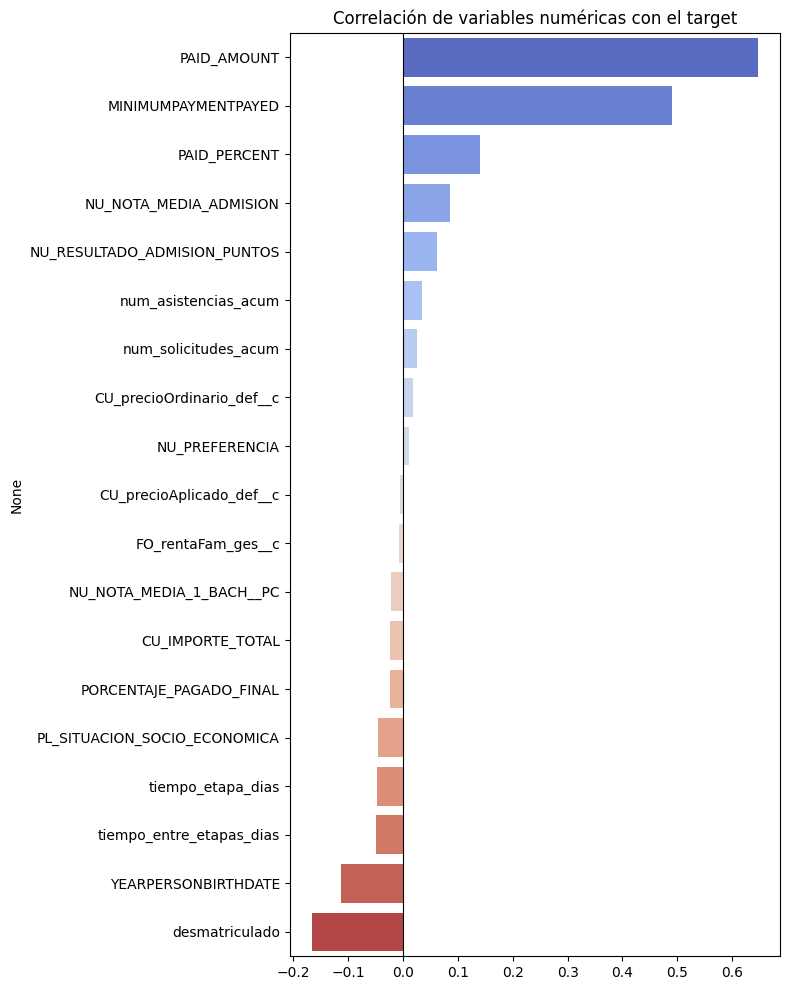

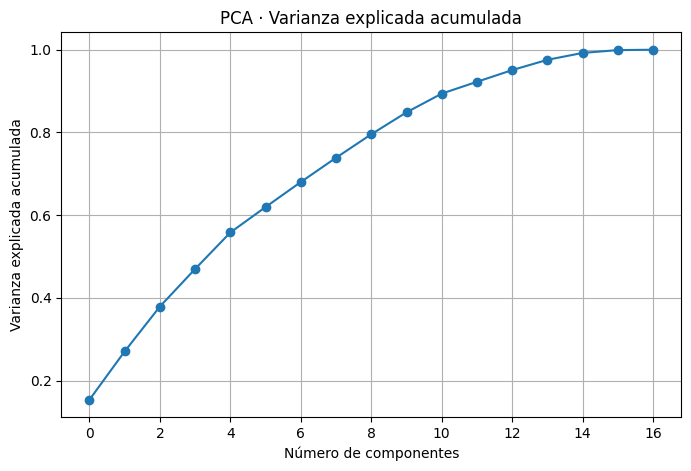

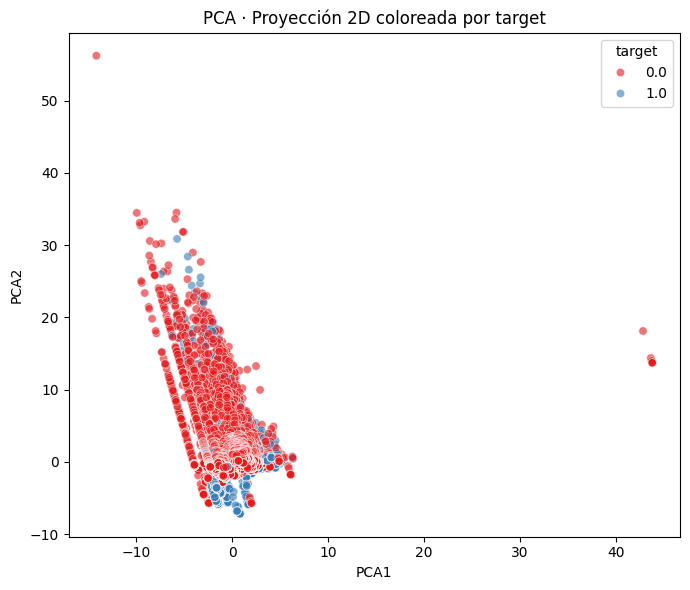

KeyboardInterrupt: 

In [2]:
# ============================================================
# SCRIPT · 02 ANÁLISIS EXPLORATORIO EN PROFUNDIDAD (OPTIMIZADO)
# ============================================================

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# ============================================================
# 0️⃣ CARGA DEL DATASET TRATADO
# ============================================================

ruta_dataset = r"..\datos\01. Datos originales\dataset_tratamiento_final.csv"
df = pd.read_csv(ruta_dataset, sep=";")

target = 'target'

# ============================================================
# 1️⃣ CORRELACIONES CON EL TARGET
# ============================================================

vars_numericas = df.select_dtypes(include=[np.number]).columns.tolist()
vars_numericas.remove(target)

corr_target = (
    df[vars_numericas + [target]]
    .corr()[target]
    .drop(target)
    .sort_values(ascending=False)
)

plt.figure(figsize=(8, 10))
sns.barplot(
    x=corr_target.values,
    y=corr_target.index,
    palette="coolwarm"
)
plt.axvline(0, color="black", linewidth=0.8)
plt.title("Correlación de variables numéricas con el target")
plt.tight_layout()
plt.show()

# ============================================================
# 2️⃣ PCA · ANÁLISIS DE COMPONENTES PRINCIPALES
# ============================================================

vars_pca = [
    c for c in vars_numericas
    if not any(x in c.lower() for x in ['id', 'account'])
]

# Juan: Esto no tiene relevancia ninguna a estas alturas, pero para que salga en condiciones,
# hay variables categóricas que se están teniendo en cuenta como numéricas y eso hace que se
# pinten cosas raras: Hay que quitar del PCA: yearpersonbirthdate, y SITUACION_SOCOECONOMICA (ya que son códigos)
# incluso "desmatriculados"

X = df[vars_pca].fillna(0)

# ============================================================
# Comparación de escalas antes de normalizar (ejemplo)
# ============================================================

X.describe().T[['min', 'max']].head()

# ============================================================
# NORMALIZACIÓN DE VARIABLES
# ============================================================
# Importante:
# - PCA y KMeans se basan en distancias
# - Si las variables tienen escalas muy diferentes,
#   aquellas con mayor rango dominan el resultado
# - Por ello, se estandarizan todas las variables numéricas
#   (media = 0, desviación típica = 1)
# ============================================================

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Tras normalización (todas las variables comparables)
pd.DataFrame(X_scaled, columns=vars_pca).describe().T[['mean', 'std']].head()

# PCA completo (solo para varianza explicada)
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel("Número de componentes")
plt.ylabel("Varianza explicada acumulada")
plt.title("PCA · Varianza explicada acumulada")
plt.grid(True)
plt.show()

# Proyección PCA 2D (visual)
pca_2 = PCA(n_components=2, random_state=42)
X_pca_2 = pca_2.fit_transform(X_scaled)

df['PCA1'] = X_pca_2[:, 0]
df['PCA2'] = X_pca_2[:, 1]

plt.figure(figsize=(7, 6))
sns.scatterplot(
    data=df,
    x='PCA1',
    y='PCA2',
    hue=target,
    palette='Set1',
    alpha=0.6
)
plt.title("PCA · Proyección 2D coloreada por target")
plt.tight_layout()
plt.show()

# ============================================================
# CLUSTERING SOBRE DATOS NORMALIZADOS
# ============================================================
# El clustering se realiza sobre:
#   - Datos normalizados
#   - Reducidos previamente con PCA
# Esto mejora:
#   - Estabilidad del modelo
#   - Interpretabilidad
#   - Visualización de clusters
# ============================================================

# PCA específico para clustering (reduce dimensionalidad)
pca_cluster = PCA(n_components=10, random_state=42)
X_cluster_pca = pca_cluster.fit_transform(X_scaled)

# Muestreo para silhouette (evita O(n²))
sample_size = min(3000, X_cluster_pca.shape[0])
idx = np.random.choice(X_cluster_pca.shape[0], sample_size, replace=False)

inertias = []
silhouettes = []
k_range = range(2, 9)

for k in k_range:
    kmeans = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10
    )
    labels = kmeans.fit_predict(X_cluster_pca)

    inertias.append(kmeans.inertia_)
    silhouettes.append(
        silhouette_score(
            X_cluster_pca[idx],
            labels[idx]
        )
    )

# Visualización métricas
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(k_range, inertias, marker='o')
ax[0].set_title("Método del codo")
ax[0].set_xlabel("Número de clusters")
ax[0].set_ylabel("Inercia")

ax[1].plot(k_range, silhouettes, marker='o')
ax[1].set_title("Silhouette score (muestreo)")
ax[1].set_xlabel("Número de clusters")

plt.tight_layout()
plt.show()

# ============================================================
# 3.2 Modelo KMeans final
# ============================================================

k_final = 5  # Ajustar según métricas

kmeans = KMeans(
    n_clusters=k_final,
    random_state=42,
    n_init=10
)

df['cluster'] = kmeans.fit_predict(X_cluster_pca)

# ============================================================
# 3.3 Visualización clusters en PCA
# ============================================================

plt.figure(figsize=(7, 6))
sns.scatterplot(
    data=df,
    x='PCA1',
    y='PCA2',
    hue='cluster',
    palette='tab10',
    alpha=0.7
)
plt.title("Clusters proyectados en PCA")
plt.tight_layout()
plt.show()

# ============================================================
# 3.4 Perfilado de clusters
# ============================================================

cluster_profile = (
    df
    .groupby('cluster')[vars_pca + [target]]
    .mean()
    .round(3)
)

print("\nPerfilado de clusters:")
print(cluster_profile)

# ============================================================
# 4️⃣ INTERPRETACIÓN AUTOMÁTICA DE CLUSTERS
# ============================================================
# Se asigna una etiqueta semántica a cada cluster
# en función de su perfil medio
# ============================================================

# Variables clave para interpretar clusters
vars_interpretacion = [
    target,
    'PORCENTAJE_PAGADO_FINAL',
    'PAID_AMOUNT',
    'num_asistencias_acum',
    'num_solicitudes_acum',
    'NU_NOTA_MEDIA_ADMISION',
    'FO_rentaFam_ges__c'
]
# Juan: Mete la renta también a ver qué pasa.
vars_interpretacion = [v for v in vars_interpretacion if v in df.columns]

cluster_summary = (
    df
    .groupby('cluster')[vars_interpretacion]
    .mean()
    .round(3)
)

print("\nResumen numérico por cluster:")
print(cluster_summary)

# ============================================================
# Reglas de interpretación
# ============================================================

def interpretar_cluster(row):
    """
    Asigna una etiqueta interpretable a cada cluster
    según su perfil medio
    """

    if row[target] >= 0.7:
        return "Alta probabilidad de matriculación"
    
    if row[target] >= 0.4 and row.get('PORCENTAJE_PAGADO_FINAL', 0) < 50:
        return "Interesados sensibles al precio"
    
    if row[target] < 0.3 and row.get('num_asistencias_acum', 0) < 1:
        return "Bajo compromiso"
    
    if row[target] < 0.5 and row.get('NU_NOTA_MEDIA_ADMISION', 0) > 7:
        return "Buen perfil académico pero indeciso"
    
    return "Perfil mixto / no dominante"


cluster_summary['interpretacion_cluster'] = cluster_summary.apply(
    interpretar_cluster,
    axis=1
)

print("\nInterpretación automática de clusters:")
print(cluster_summary[['interpretacion_cluster']])

# ============================================================
# Asignar la interpretación al dataset completo
# ============================================================

df = df.merge(
    cluster_summary[['interpretacion_cluster']],
    left_on='cluster',
    right_index=True,
    how='left'
)

# ============================================================
# Visualización final: target por cluster
# ============================================================

plt.figure(figsize=(6, 4))
sns.barplot(
    x='cluster',
    y=target,
    data=df,
    palette='tab10'
)
plt.title("Probabilidad media de éxito por cluster")
plt.tight_layout()
plt.show()

# ============================================================
# Mostrar ejemplos por cluster
# ============================================================

for c in sorted(df['cluster'].unique()):
    nombre = df.loc[df['cluster'] == c, 'interpretacion_cluster'].iloc[0]
    print(f"\n🔹 Cluster {c} → {nombre}")
    print(df[df['cluster'] == c][vars_interpretacion].mean().round(2))


# ============================================================
# GUARDAR DATASET CON CLUSTERS
# ============================================================
ruta_salida = r"..\datos\03. Datos analizados\dataset_clusterizado.csv"
df.to_csv(ruta_salida, sep=";", index=False)

print(f"Dataset con clusters guardado en: {ruta_salida}")

